# Hydro ANN 

### Load and preprocess data

In [14]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf

data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')
data = data.fillna(0)
data['BeginDate'] = pd.to_datetime(data['BeginDate']).dt.tz_localize(None)
data["Sum"] = data[["Coal", "Hydro", "Natural Gas", "Nuclear", "Oil", "Other", "Landfill Gas", "Refuse", "Solar", "Wind", "Wood"]].sum(axis=1)
data['Previous_Day'] = data['BeginDate'] - pd.Timedelta(days=1)
data['Previous_2Day'] = data['BeginDate'] - pd.Timedelta(days=2)
data['Previous_Year'] = data['BeginDate'] - pd.DateOffset(years=1)
wind_data = data[['BeginDate', 'Hydro','Previous_Day','Previous_Year','Previous_2Day']].copy()


C:\Users\Avishai\AppData\Local\Temp\ipykernel_59096\2660157751.py:6: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  data = pd.read_csv('C:/Users/Avishai/Desktop/Senior-project/Two_Year_Training_Set.csv')


In [15]:
from bisect import bisect_left

def get_previous_day_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Hydro'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Day']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]

In [16]:
from bisect import bisect_left

def get_two_days_before_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Hydro'].values
    
    # Calculate two days before
    target_date = row['BeginDate'] - pd.Timedelta(days=2)
    
    # Perform binary search to find the index of the closest date
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [17]:
from bisect import bisect_left

def get_previous_year_Wind(row, reference_df):
    # Sort reference_df by 'BeginDate' for fast lookups
    sorted_dates = reference_df['BeginDate'].values
    solar_values = reference_df['Hydro'].values
    
    # Perform binary search to find the index of the closest date
    target_date = row['Previous_Year']
    pos = bisect_left(sorted_dates, target_date)
    
    # Find the closest date and return corresponding Solar value
    if pos == 0:
        return solar_values[0]
    if pos == len(sorted_dates):
        return solar_values[-1]
    
    before = sorted_dates[pos - 1]
    after = sorted_dates[pos]
    
    # Return the Solar value corresponding to the closest date
    if abs(target_date - before) <= abs(target_date - after):
        return solar_values[pos - 1]
    else:
        return solar_values[pos]


In [18]:
# Large computation 
data['Previous_Year_Hydro'] = data.apply(get_previous_year_Wind, axis=1, reference_df=wind_data)

In [19]:
cutoff_date = pd.to_datetime("2024-9-01").tz_localize(None)
usable_data = data[data['BeginDate'] > cutoff_date].copy()
solar_data2 = usable_data[['BeginDate', 'Hydro','Previous_Day','Previous_2Day','Previous_Year']].copy()

In [20]:


usable_data['Previous_Day_Hydro'] = usable_data.apply(get_previous_day_Wind, axis=1, reference_df=solar_data2)
usable_data['Previous_2Day_Hydro'] = usable_data.apply(get_two_days_before_Wind, axis=1, reference_df=solar_data2)


In [21]:
usable_data['Hour_of_Day'] = usable_data['BeginDate'].dt.hour
usable_data['Year'] = usable_data['BeginDate'].dt.year
usable_data['Month'] = usable_data['BeginDate'].dt.month
features = usable_data[['Month','Previous_Day_Hydro','Previous_2Day_Hydro','Sum','Hour_of_Day','Previous_Year_Hydro','solarradiation','Year','precip','humidity','temp','dew','snow','snowdepth','windspeed','sealevelpressure','cloudcover','severerisk']]

# Useless Features , ,
target = usable_data['Hydro']

print("Features shape: ", features.shape)
print('Target shape: ', target.shape)

X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

scalar = StandardScaler()
X_train = scalar.fit_transform(X_train)
X_test = scalar.transform(X_test)

Features shape:  (13618, 18)
Target shape:  (13618,)


In [46]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=200, restore_best_weights=True)

from tensorflow.keras.callbacks import ReduceLROnPlateau

lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10, min_lr=1e-6)

In [47]:
from tensorflow.keras import regularizers

from tensorflow.keras.layers import LeakyReLU

model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, kernel_regularizer=regularizers.l2(0.001), input_shape=(X_train.shape[1],)),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(64, kernel_regularizer=regularizers.l2(0.01)),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(32, kernel_regularizer=regularizers.l2(0.001)),
    tf.keras.layers.Dropout(0.5),
    LeakyReLU(alpha=0.1),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.Dense(1)
])

model.compile(optimizer='adam', loss='mean_absolute_error')

istory = model.fit(X_train, y_train, epochs=10000, validation_split=0.15, batch_size=128, callbacks=[early_stopping, lr_scheduler])

test_loss = model.evaluate(X_test, y_test)
print(f'Test Loss: {test_loss}')

Epoch 1/10000


C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\Avishai\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\activations\leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(


73/73 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - loss: 522.5999 - val_loss: 509.4709 - learning_rate: 0.0010
Epoch 2/10000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 521.4667 - val_loss: 507.3302 - learning_rate: 0.0010
Epoch 3/10000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 521.4900 - val_loss: 504.5285 - learning_rate: 0.0010
Epoch 4/10000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 517.3265 - val_loss: 501.2844 - learning_rate: 0.0010
Epoch 5/10000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 509.5828 - val_loss: 497.4137 - learning_rate: 0.0010
Epoch 6/10000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 506.9575 - val_loss: 492.7581 - learning_rate: 0.0010
Epoch 7/10000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 504.6796 - val_loss: 486.9525 - learning_rate: 0.0010
Epoch 8/10000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 494.8164 - val_loss: 479.8057 - learning_rate: 0.0010
Epoch 9/10000
73/73 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - loss: 487.7871 - val_loss: 473.0805 - l

### Analysis

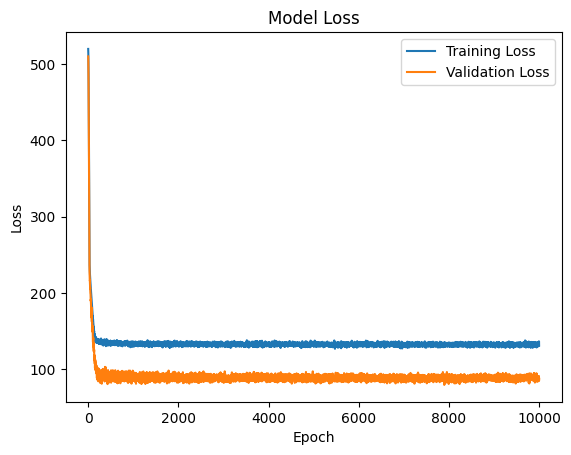

In [48]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

### Make predictions

In [49]:
import numpy as np
predictions = model.predict(X_test)
predictions[predictions < 0] = 0
flattened_predictions = [0 if (isinstance(pred, np.ndarray) and pred.item() < 0) else (0 if pred < 0 else pred.item() if isinstance(pred, np.ndarray) else pred) for pred in predictions]

print(f'Predicted Solar Energy Ouput: {flattened_predictions[:20]}')
print(f'Actual Solar Energy Output: {y_test[:20].values}')


86/86 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step
Predicted Solar Energy Ouput: [1836.129150390625, 322.12078857421875, 319.4498291015625, 1337.8634033203125, 259.6224060058594, 277.2915954589844, 1150.3963623046875, 327.8564453125, 1116.6658935546875, 1739.9664306640625, 223.82748413085938, 920.989013671875, 455.3826904296875, 584.8221435546875, 868.51171875, 268.5933532714844, 252.87197875976562, 443.6199035644531, 422.4750061035156, 332.94854736328125]
Actual Solar Energy Output: [1829.  309.  327. 1697.  232.  261. 1079.  332. 1383. 1715.  212.  971.
  452.  551.  879.  300.  247.  470.  421.  338.]


In [50]:
import numpy as np
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Assuming predictions and y_test are numpy arrays or pandas series
# predictions = model.predict(X_test)

# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, predictions)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, predictions)

# Calculate Root Mean Squared Error (RMSE)
rmse = np.sqrt(mse)
average_y_test = np.mean(y_test)
percent_error = mae / average_y_test

# Display results
print(f"Mean Absolute Error (MAE): {mae}")
print(f"Mean Squared Error (MSE): {mse}")
print(f"Root Mean Squared Error (RMSE): {rmse}")
print(f"Percent Error (PERR): {percent_error}")

Mean Absolute Error (MAE): 41.52891443619469
Mean Squared Error (MSE): 5659.797727185141
Root Mean Squared Error (RMSE): 75.23162717358399
Percent Error (PERR): 0.08146783043723332


### Save model

In [51]:
model.save('HydroModel.h5')